In [1]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing

#!pip3 install sklearn # Install machine learning library
import sklearn # For machine learning library
from sklearn.ensemble import RandomForestClassifier  # Random forest classifier
#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score

#====================================
#Read SHIPS spread-sheet data
#====================================
# Set up the location of the SHIPS data
fname='Dataset_SHIPS_RII_ATL.csv'

# Read SHIPS data
ships = pd.read_csv(fname)
ships.head()

#================================
# Set up parameters
#================================
# Year range for training and validating
year_train=['1998','2008']

# Year range for forecast
year_fcst=['2009','2017']

# Variable names for predictors
PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125

#================================
# Data pre-processing
#================================
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

# drop NaNs
ships=ships.dropna()

# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4])

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))
ships.head()

# Set the target column
ships['TAR'] = ships[TargetName].apply(lambda x: 1 if x >= RIValue else 0)
ships

,NAME,DATE,HOUR,VMX0,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
2,ALEX,980728,0,25,12.2,-29.2,1009,AL011998,5.0,10.0,10.0,10.0,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,07,1998,0
3,ALEX,980728,6,25,12.6,-31.3,1008,AL011998,5.0,10.0,10.0,15.0,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,07,1998,0
4,ALEX,980728,12,30,12.9,-33.3,1007,AL011998,5.0,5.0,5.0,10.0,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,07,1998,0
5,ALEX,980728,18,30,13.1,-35.1,1006,AL011998,5.0,5.0,10.0,15.0,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,07,1998,0
6,ALEX,980729,0,35,13.3,-36.8,1005,AL011998,0.0,0.0,5.0,10.0,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,07,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,OPHE,171013,18,80,32.0,-32.5,973,AL172017,15.0,20.0,10.0,0.0,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,10,2017,0
7393,RINA,171106,6,30,29.0,-50.7,1010,AL192017,0.0,10.0,10.0,20.0,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,11,2017,0
7394,RINA,171106,12,30,29.1,-50.4,1010,AL192017,5.0,10.0,15.0,15.0,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,11,2017,0
7395,RINA,171106,18,30,29.4,-50.2,1009,AL192017,10.0,10.0,20.0,15.0,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,11,2017,0


In [39]:
## Remove these variables below as they are merely identifers, they don't measure anything important

In [40]:
ships=ships.drop(['NAME', 'ID', 'DELV12', 'DELV24', 'DELV36', 'DELV48', 'LAT', 'LON', 'HOUR', 'DATE' , 
                 'YEAR', 'MONTH'], axis=1)

In [41]:
ships

,VMX0,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,TAR
2,25,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,0
3,25,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,0
4,30,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,0
5,30,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,0
6,35,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,80,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,0
7393,30,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,0
7394,30,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,0
7395,30,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,0


In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [43]:
Data = ships

In [44]:
Data

,VMX0,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,TAR
2,25,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,0
3,25,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,0
4,30,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,0
5,30,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,0
6,35,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,80,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,0
7393,30,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,0
7394,30,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,0
7395,30,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,0


In [45]:
## Partition the aataset into X (features only), Y (dependent variable)

In [46]:
X = Data.iloc[:,1:16]  #independent columns
Y = Data['TAR']

In [47]:
X

,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST
2,1009,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4
3,1008,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2
4,1007,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1
5,1006,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1
6,1005,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,973,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0
7393,1010,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2
7394,1010,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1
7395,1009,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9


In [14]:
Y

2       0
3       0
4       0
5       0
6       0
       ..
7379    0
7393    0
7394    0
7395    0
7396    0
Name: TAR, Length: 3743, dtype: int64

# Feature Selection Normalizing 

In [57]:
from sklearn import preprocessing

X3 = preprocessing.normalize(X)

In [58]:
X3

array([[ 0.92016032,  0.        ,  0.00784279, ...,  0.05189011,
        -0.347454  ,  0.02498751],
       [ 0.89073752,  0.        ,  0.01078075, ...,  0.04656931,
        -0.42504439,  0.02403577],
       [ 0.86655506,  0.00430266,  0.00903558, ...,  0.04758738,
        -0.44403417,  0.0233204 ],
       ...,
       [ 0.72562637,  0.        ,  0.01027372, ...,  0.03347939,
        -0.07615485,  0.01875133],
       [ 0.74012792,  0.        ,  0.01379029, ...,  0.0337422 ,
        -0.04181099,  0.01899833],
       [ 0.72476254,  0.00359505,  0.01538682, ...,  0.03307448,
        -0.01725625,  0.01840667]])

In [60]:
X3 = pd.DataFrame(X3)

In [61]:
X3.columns = X.columns

In [62]:
X3

,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST
0,0.920160,0.000000,0.007843,0.105787,0.064749,0.063837,0.011673,-0.095755,0.019151,0.000000,-0.002736,-0.008025,0.051890,-0.347454,0.024988
1,0.890738,0.000000,0.010781,0.080414,0.062740,0.050369,0.010781,-0.088367,0.025626,0.000000,-0.038881,-0.005302,0.046569,-0.425044,0.024036
2,0.866555,0.004303,0.009036,0.075727,0.061098,0.071424,0.008691,-0.076587,0.012908,0.163501,-0.039584,-0.005593,0.047587,-0.444034,0.023320
3,0.956127,0.004752,0.009219,0.041819,0.068431,0.033265,0.015112,-0.081737,0.020909,0.014256,0.034215,-0.006843,0.053794,-0.256615,0.025757
4,0.907001,0.004512,0.008935,0.033392,0.066784,0.050539,0.013086,-0.072199,0.021660,0.000000,-0.005415,-0.009296,0.052074,-0.399802,0.024457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,0.817581,-0.008403,0.008151,0.004201,0.052097,0.037812,0.010251,-0.020166,0.000000,0.487356,0.020166,0.020166,0.044114,-0.293254,0.021847
3739,0.747719,0.000000,0.010957,0.010364,0.049601,0.024430,0.021765,-0.069590,0.000740,0.639633,0.087357,0.013326,0.033832,-0.117710,0.019396
3740,0.725626,0.000000,0.010274,0.003592,0.047417,0.020116,0.018823,-0.066815,0.000000,0.671025,0.090524,0.011639,0.033479,-0.076155,0.018751
3741,0.740128,0.000000,0.013790,0.002201,0.047679,0.019805,0.017971,-0.066017,0.000000,0.656506,0.101227,0.013203,0.033742,-0.041811,0.018998


In [66]:
model2 = ExtraTreesClassifier()
model2.fit(X3,Y)
print(model2.feature_importances_) 

[0.05918091 0.07777075 0.07275891 0.06250917 0.06802618 0.06460201
 0.06350816 0.08463248 0.0682838  0.04420526 0.0626289  0.07552854
 0.06767998 0.06604677 0.06263815]


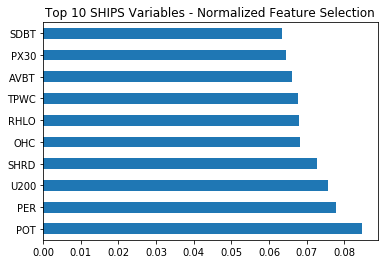

In [71]:
feat_importances = pd.Series(model2.feature_importances_, index=X3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 SHIPS Variables - Normalized Feature Selection")
plt.show()


# Model implementation using normalized data

In [200]:
X3

,MSLP,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST
0,0.920160,0.000000,0.007843,0.105787,0.064749,0.063837,0.011673,-0.095755,0.019151,0.000000,-0.002736,-0.008025,0.051890,-0.347454,0.024988
1,0.890738,0.000000,0.010781,0.080414,0.062740,0.050369,0.010781,-0.088367,0.025626,0.000000,-0.038881,-0.005302,0.046569,-0.425044,0.024036
2,0.866555,0.004303,0.009036,0.075727,0.061098,0.071424,0.008691,-0.076587,0.012908,0.163501,-0.039584,-0.005593,0.047587,-0.444034,0.023320
3,0.956127,0.004752,0.009219,0.041819,0.068431,0.033265,0.015112,-0.081737,0.020909,0.014256,0.034215,-0.006843,0.053794,-0.256615,0.025757
4,0.907001,0.004512,0.008935,0.033392,0.066784,0.050539,0.013086,-0.072199,0.021660,0.000000,-0.005415,-0.009296,0.052074,-0.399802,0.024457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,0.817581,-0.008403,0.008151,0.004201,0.052097,0.037812,0.010251,-0.020166,0.000000,0.487356,0.020166,0.020166,0.044114,-0.293254,0.021847
3739,0.747719,0.000000,0.010957,0.010364,0.049601,0.024430,0.021765,-0.069590,0.000740,0.639633,0.087357,0.013326,0.033832,-0.117710,0.019396
3740,0.725626,0.000000,0.010274,0.003592,0.047417,0.020116,0.018823,-0.066815,0.000000,0.671025,0.090524,0.011639,0.033479,-0.076155,0.018751
3741,0.740128,0.000000,0.013790,0.002201,0.047679,0.019805,0.017971,-0.066017,0.000000,0.656506,0.101227,0.013203,0.033742,-0.041811,0.018998


In [201]:
Model_Data = X[['POT', 'PER', 'U200', 'SHRD', 'OHC']]

In [202]:
Model_Data

,POT,PER,U200,SHRD,OHC
2,-105,0.0,-8.8,8.6,21.0
3,-100,0.0,-6.0,12.2,29.0
4,-89,5.0,-6.5,10.5,15.0
5,-86,5.0,-7.2,9.7,22.0
6,-80,5.0,-10.3,9.9,24.0
...,...,...,...,...,...
7379,-24,-10.0,24.0,9.7,0.0
7393,-94,0.0,18.0,14.8,1.0
7394,-93,0.0,16.2,14.3,0.0
7395,-90,0.0,18.0,18.8,0.0


In [203]:
Y = pd.DataFrame(Y)

In [204]:
Y

,TAR
2,0
3,0
4,0
5,0
6,0
...,...
7379,0
7393,0
7394,0
7395,0


In [205]:
Model_Data = pd.concat([Model_Data, Y], axis = 1 )

In [206]:
Model_Data

,POT,PER,U200,SHRD,OHC,TAR
2,-105,0.0,-8.8,8.6,21.0,0
3,-100,0.0,-6.0,12.2,29.0,0
4,-89,5.0,-6.5,10.5,15.0,0
5,-86,5.0,-7.2,9.7,22.0,0
6,-80,5.0,-10.3,9.9,24.0,0
...,...,...,...,...,...,...
7379,-24,-10.0,24.0,9.7,0.0,0
7393,-94,0.0,18.0,14.8,1.0,0
7394,-93,0.0,16.2,14.3,0.0,0
7395,-90,0.0,18.0,18.8,0.0,0


In [207]:
Model_Data['TAR'].value_counts()

0    3416
1     327
Name: TAR, dtype: int64

In [208]:
 import numpy as np
from sklearn.model_selection import train_test_split

In [209]:
X_train, X_test= train_test_split( Model_Data, test_size=0.30, random_state=42)

In [210]:
X_train

,POT,PER,U200,SHRD,OHC,TAR
2482,-61,15.0,-3.4,8.8,125.0,0
4736,-71,20.0,-16.0,11.6,88.0,1
5730,-93,10.0,13.9,16.9,23.0,0
1872,-79,-10.0,-20.9,32.5,33.0,0
5325,-88,-5.0,-0.1,22.6,49.0,0
...,...,...,...,...,...,...
2293,-66,10.0,4.7,6.1,6.0,0
2571,-36,-15.0,13.0,19.6,69.0,0
1845,-79,5.0,9.6,11.5,15.0,0
6980,-78,0.0,7.6,24.4,15.0,0


In [211]:
X_test

,POT,PER,U200,SHRD,OHC,TAR
6807,-109,15.0,-6.9,14.7,30.0,0
2277,-87,5.0,12.8,20.0,34.0,0
572,-50,-10.0,23.1,24.8,51.0,0
5692,-97,0.0,13.3,18.3,44.0,0
4608,-114,25.0,13.9,17.0,89.0,1
...,...,...,...,...,...,...
5742,-57,0.0,3.2,8.7,1.0,0
7259,-90,5.0,10.7,1.3,10.0,1
6519,-41,-10.0,7.8,9.6,50.0,0
1947,-94,10.0,-3.0,6.9,129.0,0


In [187]:
X_train.TAR.value_counts()

0    2397
1     223
Name: TAR, dtype: int64

In [212]:
Y_train = X_train['TAR']

In [213]:
X_train = X_train.drop('TAR', axis = 1 )

In [214]:
X_train

,POT,PER,U200,SHRD,OHC
2482,-61,15.0,-3.4,8.8,125.0
4736,-71,20.0,-16.0,11.6,88.0
5730,-93,10.0,13.9,16.9,23.0
1872,-79,-10.0,-20.9,32.5,33.0
5325,-88,-5.0,-0.1,22.6,49.0
...,...,...,...,...,...
2293,-66,10.0,4.7,6.1,6.0
2571,-36,-15.0,13.0,19.6,69.0
1845,-79,5.0,9.6,11.5,15.0
6980,-78,0.0,7.6,24.4,15.0


In [215]:
from imblearn.under_sampling import NearMiss
sm= NearMiss()

In [216]:
X_train_balanced, Y_train_balanced = sm.fit_sample(X_train, Y_train) 

In [217]:
X_train_balanced

,POT,PER,U200,SHRD,OHC
0,-87,5.0,2.5,14.4,32.0
1,-95,5.0,-11.4,10.0,32.0
2,-84,5.0,5.3,14.5,28.0
3,-84,15.0,0.1,10.1,40.0
4,-83,10.0,-15.0,10.7,26.0
...,...,...,...,...,...
441,-63,20.0,4.4,19.4,101.0
442,-59,5.0,-9.6,1.5,27.0
443,-53,10.0,-4.0,5.7,49.0
444,-111,25.0,-2.7,20.1,66.0


In [218]:
Y_train_balanced.value_counts()

1    223
0    223
Name: TAR, dtype: int64

In [239]:
model = RandomForestClassifier(n_estimators=250, n_jobs=-30, random_state=66, max_depth=30)

In [240]:
model.fit(X_train_balanced,Y_train_balanced)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-30, oob_score=False, random_state=66, verbose=0,
                       warm_start=False)

In [221]:
X_test

,POT,PER,U200,SHRD,OHC,TAR
6807,-109,15.0,-6.9,14.7,30.0,0
2277,-87,5.0,12.8,20.0,34.0,0
572,-50,-10.0,23.1,24.8,51.0,0
5692,-97,0.0,13.3,18.3,44.0,0
4608,-114,25.0,13.9,17.0,89.0,1
...,...,...,...,...,...,...
5742,-57,0.0,3.2,8.7,1.0,0
7259,-90,5.0,10.7,1.3,10.0,1
6519,-41,-10.0,7.8,9.6,50.0,0
1947,-94,10.0,-3.0,6.9,129.0,0


In [233]:
Y_test

6807    0
2277    0
572     0
5692    0
4608    1
       ..
5742    0
7259    1
6519    0
1947    0
7169    0
Name: TAR, Length: 1123, dtype: int64

In [222]:
Y_test = X_test.TAR

In [223]:
X_test = X_test.drop('TAR', axis = 1 )

In [224]:
Y_pred = model.predict(X_test)

In [225]:
Y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [226]:
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss

In [241]:
cmatrix = confusion_matrix(Y_test, Y_pred)
cmatrix

array([[278, 741],
       [ 27,  77]], dtype=int64)

In [232]:
cmatrix[0,0]

278

In [228]:
pss=((cmatrix[0,0] * cmatrix[1,1]) - (cmatrix[0,1] * cmatrix[1,0])) * 1.0 / ((cmatrix[1,1] + cmatrix[1,0]) * (cmatrix[0,1] + cmatrix[0,0]))
pss

0.013201102136332755

In [229]:
far=(cmatrix[0,1] * 1.0) / (cmatrix[0,1] + cmatrix[1,1])
far

0.9058679706601467

In [230]:
pod=(cmatrix[1,1] * 1.0) / (cmatrix[1,0] + cmatrix[1,1]) 
pod

0.7403846153846154

In [242]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.3161175422974176

In [ ]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

In [243]:
from sklearn import tree

In [244]:
 clf = tree.DecisionTreeClassifier()

In [245]:
clf = clf.fit(X_train_balanced, Y_train_balanced)

In [247]:
Y_pred = clf.predict(X_test)

In [248]:
cmatrix = confusion_matrix(Y_test, Y_pred)
cmatrix

array([[397, 622],
       [ 43,  61]], dtype=int64)

In [249]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.40783615316117544